# Global olarak 2 boyutlu problemin modellenmesi

Bu derste ders 7 kapsamında daha önce gördüğümüz tüm bilgileri kullanarak global olarak sistemin tamamını çözümleyeceğiz. Çözeceğimiz problemi tekrar göz önüne getirelim:

<img src="Resimler/Ders7/2BoyutluProblem.png" align="center" width= "600"/>

İlk olarak problemin parametrelerini belirleyerek başlayalım:

In [1]:
L = 2    # m
H = 2    # m
D = 0.05 # m

q_1 = -500  # W/m2
q_2 = -1000 # W/m2
q_3 = -1500 # W/m2

T_sonsuz = 30 # C
T_sol = 80    # C
k = 5  # W/m2.K
h = 10 # W/m2K
h_z = 2*h/D

Şimdi bu derste kullanacağımız kütüphaneleri çağıralım:

In [2]:
import sympy as sp
import numpy as np
from scipy import integrate
from sympy.utilities import lambdify

Bu bölümde problemin tamamını çözeceğimiz için 2x2lik bir ağ yapısını noktaları ve elemanları numaralandırılmiş bir biçimde gösterelim: 

<img src="Resimler/Ders7/7e_TamMesh.png" align="center" width= "600"/>

Şekilde görüldüğü üzere eleman numaraları ve nokta numaraları soldan sağa artacak şekilde belirlenmiştir. 

## Geometri sınıfının oluşturulması

Bu ağ yapısını belirtilen numaralandırma metoduna göre oluşturan, uzunluğu ve genişliğine ek olarak *x* ve *y* eksenlerindeki eleman sayısı da belirlenebilen bir *Dikdörtgen* sınıfı tanımlayalalım. 

In [3]:
class Dikdörtgen():
    
    def __init__(self, L, H, nx, ny):
        
        x = np.linspace(0, L, nx+1)
        y = np.linspace(0, H, ny+1)
        ağ = np.meshgrid(x, y)

        noktalar = np.zeros(((nx+1)*(ny+1), 2), dtype=np.float32)
        elemanlar = np.zeros((nx*ny, 4), dtype=np.int32)

        nokta = 0
        for iy in range(ny + 1):
            for ix in range(nx + 1):
                noktalar[nokta, :] = x[ix], y[iy]
                nokta += 1

        eleman = 0
        for iy in range(ny):
            for ix in range(nx):
                v0 = iy*(nx + 1) + ix
                v1 = v0 + 1
                v2 = v0 + nx+1
                v3 = v1 + nx+1
                elemanlar[eleman, :] = v0, v1, v3, v2
                eleman += 1

        self.elemanlar = elemanlar
        self.noktalar = noktalar
        self.N = len(noktalar) # toplam nokta sayısı
        self.ağ = ağ
        self.nx = nx
        self.ny = ny

        self.sağ_kenar_noktalar = []
        self.üst_kenar_noktalar = []
        self.sol_kenar_noktalar = []
        self.alt_kenar_noktalar = []

        for indis, nokta in enumerate(self.noktalar):
            if np.isclose(nokta[0], L):
                self.sağ_kenar_noktalar.append(indis)
            if np.isclose(nokta[1], H):
                self.üst_kenar_noktalar.append(indis)
            if np.isclose(nokta[0], 0):
                self.sol_kenar_noktalar.append(indis)
            if np.isclose(nokta[1], 0):
                self.alt_kenar_noktalar.append(indis)
        
        eleman_id = np.arange(0,nx*ny)

        self.kenar_elemanlar = {'sağ':eleman_id[nx-1::nx],
                                'üst':eleman_id[-nx:],
                                'sol':eleman_id[0::nx],
                                'alt':eleman_id[:nx]
                                }

Şimdi bu sınıfı kullanarak 2x2lik dikdörtgen plakayı tanımlayabiliriz:

In [4]:
nx, ny = 2, 2
plaka = Dikdörtgen(L,H,nx,ny)

Tanımladığımız plakanın elemanlarına ve o elemanlara ait noktaların global indislerine ulaşmak için *Dikdörtgen* sınıfının *elemanlar* özelliğini kullanabiliriz:

In [5]:
plaka.elemanlar

array([[0, 1, 4, 3],
       [1, 2, 5, 4],
       [3, 4, 7, 6],
       [4, 5, 8, 7]], dtype=int32)

Yukarıdaki şekilden de teyit edilebileceği üzere *plaka.elemanlar* dizisinin ilk elemanı olan alt-dizi, 0. elemana ait noktaları saat yönünün tersi yönünde sol alt köşeden başlayarak sırasıyla göstermektedir. Benzer şekilde oluşturduğumuz ağın noktalarına da

In [6]:
plaka.noktalar

array([[0., 0.],
       [1., 0.],
       [2., 0.],
       [0., 1.],
       [1., 1.],
       [2., 1.],
       [0., 2.],
       [1., 2.],
       [2., 2.]], dtype=float32)

yazarak ulaştığımızda soldan sağa doğru sıralanmış noktalara ait diziye ulaşabiliriz. Bu sınıfla ilgili olarak herhangi bir kenardaki eleman indislerine ulaşmak için *Dikdörtgen* sınıfına ait olan *kenar_elemanlar* özelliğini kullanabiliriz. Örneğin ağımızın sol kenarında bulunan elemanların indislerini aşağıda olduğu gibi erişebiliriz:

In [7]:
plaka.kenar_elemanlar['sol']

array([0, 2])

## Fonksiyon uzayı sınıfının tanımlanması

Eğitimin 7. bölümündeki diğer derslerde anlatıldığı üzere matris ve vektörleri oluştururken dikdörtgen şekil fonksiyonlarından sürekli olarak faydalandık. Bu bölümde kullanacağımız referans şeklin yerel numaralarını tekrar gösterelim:

<img src="Resimler/Ders7/7e_referansEleman.png" align="center" width= "300"/>


Yerel matrisleri ve vektörleri tanımlarken sürekli olarak bu referans elemana ait şekil fonksiyonlarını ve onun değişkenlerini kullanmamız gerekeceğinden *FonksiyonUzayı* adı altında bir sınıf tanımlayalım: 

In [8]:
class FonksiyonUzayı():
    
    def __init__(self, mesh):
        self.mesh = mesh
        xi = sp.Symbol("xi")
        eta = sp.Symbol("eta")
        x_ = sp.symbols("x1,x2,x3,x4")
        y_ = sp.symbols("y1,y2,y3,y4")
        
        şekil = sp.Matrix([ (1-xi)*(1-eta)/4,
                            (1+xi)*(1-eta)/4,
                            (1+xi)*(1+eta)/4,
                            (1-xi)*(1+eta)/4])
        
        self.nokta_sayısı = 4

        gradyen_xi = sp.diff(şekil, xi)
        gradyen_eta = sp.diff(şekil, eta)

        gradyen = sp.Matrix([gradyen_eta, gradyen_xi])
        
        # Ders 7c'de Jakobyen oluşturuken kullandığımız fonksiyon
        c_şekil = sp.Matrix([0, 0])
        for i in range(self.nokta_sayısı):
            c_şekil[0] += x_[i] * şekil[i]
            c_şekil[1] += y_[i] * şekil[i]

        self.gradyen = gradyen.reshape(2,4)
        self.şekil = şekil
        self.eta   = eta
        self.xi    = xi
        self.x_ = x_
        self.y_ = y_
        
        self.J = c_şekil.jacobian([xi, eta]).T
        self._dofmap = lambda e, r: self.mesh.elemanlar[e, r]
    
    def lokal_jakobyen(self, eleman_no):
        # Elemana ait noktaların global indislerini içeren dizi
        eleman_nokta_indisler = self.mesh.elemanlar[eleman_no]
        # Elemana ait koordinatların x ve y noktalarını içeren dizi
        eleman_noktalar = np.take(self.mesh.noktalar, eleman_nokta_indisler, axis=0)
        
        J = self.J

        for indis, nokta in enumerate(eleman_noktalar):
            J = J.subs(self.x_[indis],nokta[0]) # x koordinatı 
            J = J.subs(self.y_[indis],nokta[1]) # y koordinatı
        
        return J

Yukarıda tanımlanan fonksiyon uzayı sınıfı, ders 7c ve ders 7d'de kullanılan şekil fonksiyonlarına hızla erişmemize olanak sağlayacaktır. Şimdi problemimizin ağı olan *plaka* değişkenine özel olarak bir fonksiyon uzayı değişkeni tanımlayabiliriz:

In [9]:
V = FonksiyonUzayı(plaka)

## Global iletim ve taşınım matrislerinin hesaplanması

Global iletim ve taşınım matrislerinin hesaplanması için ders 7c'de kullandığımız kodların birebir aynısını *fonksiyon uzayı* değişkenini içerecek şekilde yazabiliriz. Bu durumda yerel eleman için iletim matrisini hesaplayan matris:

In [10]:
def K_e_eleman(V, eleman_no, k):

    J = V.lokal_jakobyen(eleman_no)

    K_e_sym = V.gradyen.T*(J**(-1)).T*k*(J**(-1))*V.gradyen*J.det()

    K_e = np.zeros((V.nokta_sayısı,V.nokta_sayısı))

    for i in range(V.nokta_sayısı):
        for j in range(V.nokta_sayısı):
            geçici_fonksiyon = lambdify( (V.xi,V.eta), K_e_sym[i,j], 'math' )
            K_e[i,j] += integrate.nquad(geçici_fonksiyon, [[-1, 1],[-1, 1]])[0]
            
    return K_e

olarak yazılabilir. Benzer şekilde yerel eleman için taşınım matrisini hesaplayan matris

In [11]:
def K_t_eleman(V, eleman_no, h_z):

    J = V.lokal_jakobyen(eleman_no)

    K_t_sym = h_z*V.şekil*V.şekil.T*J.det()

    K_t = np.zeros((V.nokta_sayısı,V.nokta_sayısı))
    
    for i in range(V.nokta_sayısı):
        for j in range(V.nokta_sayısı):
            geçici_fonksiyon = lambdify( (V.xi,V.eta), K_t_sym[i,j], 'math' )
            K_t[i,j] += integrate.nquad(geçici_fonksiyon, [[-1, 1],[-1, 1]])[0]
    return K_t

olarak oluşturulabilir. Elde ettiğimiz **K_e** ve **K_t** matrislerini, global ağ'ı temsil eden *plaka* değişkeninin noktalarına karşılık geleccek şekilde uygun yerlere yerleştirmemiz gerekir. Bu yüzden yerel elemanların yerel nokta numaralarını global ağ'daki nokta numaralarına eşleyecek şekilde global **K** matrisini oluşturmamız önemlidir. 

Örneğin, yukarıda belirtilen 2x2lik ağda eleman 1' ait yerel numaralar sol alt köşeden başlayarak 0,1,2,3 iken global olarak 1,2,5,4 olmaktadır. Yani eleman 1'in yerelde 2 numaralı noktası globalde 5 numaralı noktaya karşılık gelir. Bu sebeple, eleman 1'e ait herhangi bir yerel eleman matrisinin (taşınım, iletim vb.)  3. satırı 3. sütunu,  global matriste 5. satır 5. sütuna denk gelecektir. 

Buradan hareketle öncekikle yukarıda fonksiyonlarını tanımladığımız yerel iletim ve lokal taşınım matrislerini herbir eleman için hesaplayıp toplamalıyız. Ardından elde ettiğimiz lokal **K**($K_e+K_t$) matrisini global matristeki uygun satır ve sütunlara yerleştirmeliyiz. Bu işlemleri yapan ve global **K** matrisini hesaplayan fonksiyonu aşağıdaki şekilde yazabiliriz:

In [12]:
np.set_printoptions(linewidth=150)

def K_global_hesapla(V, k, h_z):
    
    mesh = V.mesh
    K_global = np.zeros((mesh.N, mesh.N))

    for eleman_no, eleman in enumerate(mesh.elemanlar):
        K_lokal = K_e_eleman(V, eleman_no, k) + K_t_eleman(V, eleman_no,h_z)
        for lokal_x, global_x in enumerate(eleman):
            for lokal_y, global_y in enumerate(eleman):
                K_global[global_x][global_y] += K_lokal[lokal_x][lokal_y]
    return K_global

K_global = K_global_hesapla(V, k, h_z)
K_global

array([[ 47.77777778,  21.38888889,   0.        ,  21.38888889,   9.44444444,   0.        ,   0.        ,   0.        ,   0.        ],
       [ 21.38888889,  95.55555556,  21.38888889,   9.44444444,  42.77777778,   9.44444444,   0.        ,   0.        ,   0.        ],
       [  0.        ,  21.38888889,  47.77777778,   0.        ,   9.44444444,  21.38888889,   0.        ,   0.        ,   0.        ],
       [ 21.38888889,   9.44444444,   0.        ,  95.55555556,  42.77777778,   0.        ,  21.38888889,   9.44444444,   0.        ],
       [  9.44444444,  42.77777778,   9.44444444,  42.77777778, 191.11111111,  42.77777778,   9.44444444,  42.77777778,   9.44444444],
       [  0.        ,   9.44444444,  21.38888889,   0.        ,  42.77777778,  95.55555556,   0.        ,   9.44444444,  21.38888889],
       [  0.        ,   0.        ,   0.        ,  21.38888889,   9.44444444,   0.        ,  47.77777778,  21.38888889,   0.        ],
       [  0.        ,   0.        ,   0.        ,   9.4

Görüldüğü üzere 2x2lik ağ'a ait **K** matrisini elde ettik.

## Global taşınım ve sınır koşulu vektörlerinin hesaplanması


Bu böümde ise ders 7d'de anlatılan eleman vektörlerini global olarak ele alacağız. İlk önce yatay ve dikey sınırlardan gerçekleşen ısı transfer sınır koşulunu eleman bazında hesaplayan fonksiyonları yazalım: 

In [13]:
def f_e_1_eleman_yatay(V, eleman_no, q_eta, kenar):

    J = V.lokal_jakobyen(eleman_no)
        
    q_eta = sp.Matrix(q_eta)

    f_e_1_sym_yatay = V.şekil.multiply_elementwise(q_eta)*sp.sqrt(J[1,0]**2+J[1,1]**2)

    if kenar == 'üst':
        kenar_değer = 1
    elif kenar == 'alt':
        kenar_değer = -1

    f_e_1_sym_yatay = f_e_1_sym_yatay.subs(V.eta, kenar_değer) 

    f_e_1_yatay = np.zeros(V.nokta_sayısı)

    for i in range(V.nokta_sayısı):
        yatay_fonksiyon = lambdify( V.xi, f_e_1_sym_yatay[i], 'math' )
        f_e_1_yatay[i] += integrate.quad(yatay_fonksiyon, -1, 1)[0]
        
    return f_e_1_yatay

def f_e_1_eleman_dikey(V, eleman_no, q_xi, kenar):

    J = V.lokal_jakobyen(eleman_no)
        
    q_xi  = sp.Matrix(q_xi)

    f_e_1_sym_dikey = V.şekil.multiply_elementwise(q_xi)*sp.sqrt(J[0,0]**2+J[0,1]**2)

    if kenar == 'sağ':
        kenar_değer = 1
    elif kenar == 'sol':
        kenar_değer = -1

    f_e_1_sym_dikey = f_e_1_sym_dikey.subs(V.xi,kenar_değer) 

    f_e_1_dikey = np.zeros(V.nokta_sayısı)

    for i in range(V.nokta_sayısı):
        dikey_fonksiyon = lambdify(V.eta, f_e_1_sym_dikey[i], 'math' )
        f_e_1_dikey[i] += integrate.quad(dikey_fonksiyon, -1, 1)[0]
        
    return f_e_1_dikey

Şimdi de ders 7d'de gösterilen, plakanın kendisinden ısı taşınımını modelleyen taşınım vektörünü hesaplayan bir fonksiyon yazalım: 

In [14]:
def f_e_2_eleman(V, eleman_no, h, t_z, T_sonsuz):

    J = V.lokal_jakobyen(eleman_no)

    h_z = 2*h/t_z

    f_e_2_sym = h_z*T_sonsuz*V.şekil*J.det()
    
    f_e_2 = np.zeros((V.nokta_sayısı,1))

    for i in range(V.nokta_sayısı):
        taşınım_fonksiyon = lambdify( (V.xi, V.eta), f_e_2_sym[i], 'math' )
        f_e_2[i] += integrate.nquad(taşınım_fonksiyon, [[-1, 1],[-1, 1]])[0]

    return f_e_2

Tıpkı global **K** matrisini hesaplarken yaptığımız gibi global **f** vektörünü hesaplarken de lokal eleman vektörlerini global **f** vektöründe uygun yerlere yerleştirmemiz gerekmektedir. Aşağıdaki fonksiyon ile bu işlemi gerçekleştirebiliriz:

In [15]:
def f_global_hesapla(V, q_1, q_2, q_3):

    mesh = V.mesh
    
    f_global = np.zeros(mesh.N)

    # Her bir eleman için x ve y yönünde gerçekleşen ısı transferi vektörleri
    q_x = np.zeros((mesh.N))
    q_y = np.zeros((mesh.N))

    # Kenarlardan gerçekleşen ısı transfer değerlerinin tanımlanması
    q_y[mesh.üst_kenar_noktalar] += q_1
    q_x[mesh.sağ_kenar_noktalar] += q_2
    q_y[mesh.alt_kenar_noktalar] += q_3

    # Sağ kenardan taşınımla gerçekleşen ısı transferi
    for eleman in plaka.kenar_elemanlar['sağ']:
        q_xi = q_x[plaka.elemanlar[eleman]] 
        f_lokal_1 = f_e_1_eleman_dikey(V, eleman, q_xi, 'sağ')
        for lokal_x, global_x in enumerate(plaka.elemanlar[eleman]):
            f_global[global_x] += f_lokal_1[lokal_x]

    # Üst kenardan taşınımla gerçekleşen ısı transferi
    for eleman in plaka.kenar_elemanlar['üst']:
        q_eta = q_y[plaka.elemanlar[eleman]] 
        f_lokal_1 = f_e_1_eleman_yatay(V, eleman, q_eta, 'üst')
        for lokal_x, global_x in enumerate(plaka.elemanlar[eleman]):
            f_global[global_x] += f_lokal_1[lokal_x]

    # Sol kenardan taşınımla gerçekleşen ısı transferi
    for eleman in plaka.kenar_elemanlar['sol']:
        q_xi = q_x[plaka.elemanlar[eleman]] 
        f_lokal_1 = f_e_1_eleman_dikey(V, eleman, q_xi, 'sol')
        for lokal_x, global_x in enumerate(plaka.elemanlar[eleman]):
            f_global[global_x] += f_lokal_1[lokal_x]

    # Alt kenardan taşınımla gerçekleşen ısı transferi
    for eleman in plaka.kenar_elemanlar['alt']:
        q_eta = q_y[plaka.elemanlar[eleman]] 
        f_lokal_1 = f_e_1_eleman_yatay(V, eleman, q_eta, 'alt')
        for lokal_x, global_x in enumerate(plaka.elemanlar[eleman]):
            f_global[global_x] += f_lokal_1[lokal_x]

    # Plaka üzerinden taşınımla gerçekleşen ısı transferi
    for eleman_no, eleman in enumerate(plaka.elemanlar):
        f_lokal_2 = f_e_2_eleman(V, eleman_no, h, D, T_sonsuz)
        for lokal_x, global_x in enumerate(eleman):
            f_global[global_x] += f_lokal_2[lokal_x]

    return f_global

f_global = f_global_hesapla(V, q_1, q_2, q_3)

Bu noktaya kadar tüm sınır koşullarını sabit sıcaklık (Dirichlet) sınır koşulu hariç tanımlamış olduk. Sol kenardaki sabit sıcaklık değerini global matris ve vektüründe tanımlamak için yine ders 5'te kullandığımız penaltı yöntemini kullanacağız. Genel sınır koşulu denklemini tekrar hatırlayalım:

$$
\begin{equation}
\alpha \frac{dT}{dx}(x) + \beta T(x) = \gamma 
\end{equation} \tag{14}
$$

Bu durumda sol kenar sınır koşulu için $\alpha=0$, $\beta=1$ ve $\gamma=T_{sol}=80$ olacaktır. 2x2lik ağda sol kenarda 3 adet nokta olduğu için her bir nokta için bu noktaların global matris ve global vektör değerlerini uygun bir manipüle edecek fonksiyonu yazalım:

In [16]:
alpha = 10e-12
beta  = 1
gamma = T_sol
A = H/(ny+1)*D

def dirichlet_uygula(kenar, K_global, f_global, alpha, beta, gamma, A, k):

    for nokta in kenar:
        K_global[nokta,nokta]+= 1*beta*k*A/alpha  
        f_global[nokta] += 1*gamma*k*A/alpha
    
    return K_global, f_global

K_global, f_global = dirichlet_uygula(plaka.sol_kenar_noktalar, K_global, f_global, alpha, beta, gamma, A, k)

## Global sistemin çözümü

Artık elde ettiğimiz global **K** matrisini ve global **f** vektörünü değerlerini *scipy* kütüphanesinin *solve* fonksiyonunda kullanarak sonuca ulaşabiliriz.

In [17]:
from scipy.linalg import solve

def sistemi_çöz(mesh, K_global, f_global):
    u = solve(K_global,f_global)
    # Çözüm vektörünü çözüm ağına göre yeniden boyutlandırmak
    u_plot = u.reshape(mesh.ny+1, mesh.nx+1)
    return u_plot

T = sistemi_çöz(plaka, K_global, f_global)
T

array([[79.99999978,  3.61646563, 16.27618081],
       [79.99999962, 24.46239928, 31.04295419],
       [79.9999998 , 12.64368251, 22.70004302]])

## Çözümün görselleştirilmesi

Son olarak çözümü *matplotlib* kütüphanesinin *contourf* fonksiyonu ile görselleştirerek plaka üzerindeki ısı dağılımını gözlemleyebiliriz:

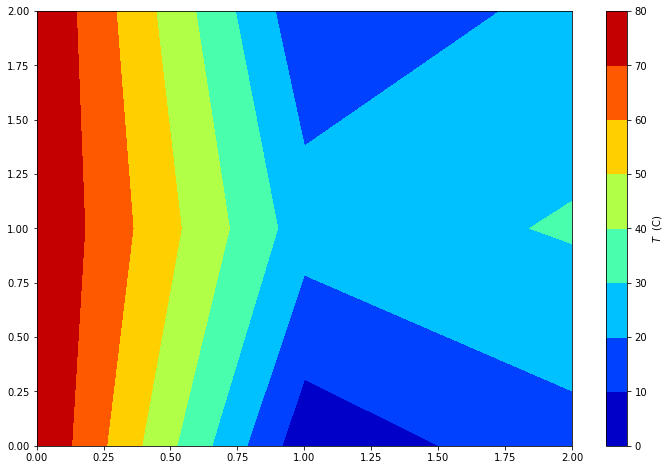

In [18]:
import matplotlib.pyplot as plt

def çözümü_görselleştir(plaka, T):
    fig, ax = plt.subplots()
    fig.set_size_inches(12,8)
    X,Y = plaka.ağ

    grafik = ax.contourf(X, Y, T, cmap='jet')
    cbar = plt.colorbar(grafik)
    cbar.set_label(r"$T$  (C)")
    plt.plot()

çözümü_görselleştir(plaka, T)

## Çözümün hassaslaştırılması

Bu tarz problemler için daha fazla elemanladan oluşan bir ağ(mesh) kullanılarak daha hassas numerik çözüm elde edilebilir. Bunun için bu ders boyunca geliştirdiğimiz fonksiyonları farklı bir geometri ve fonksiyon uzayı için tekrar kullanarak daha hassas sıcaklık dağılımı elde edebiliriz:  

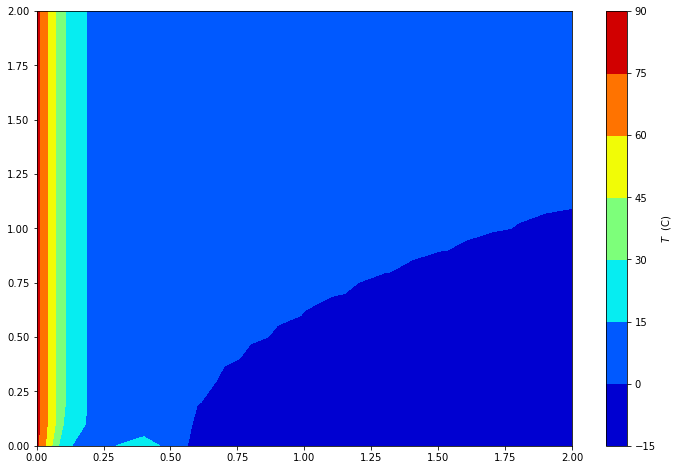

In [19]:
nx2, ny2 = 20, 20

plaka2 = Dikdörtgen(L,H,nx2,ny2)
V2 = FonksiyonUzayı(plaka2)

K_global2 = K_global_hesapla(V2, k, h_z)
f_global2 = f_global_hesapla(V2, q_1, q_2, q_3)

A2 = H/(ny2+1)*D
K_global2, f_global2 = dirichlet_uygula(plaka2.sol_kenar_noktalar, K_global2, f_global2, alpha, beta, gamma, A2, k)

T2 = sistemi_çöz(plaka2, K_global2, f_global2)
çözümü_görselleştir(plaka2, T2)


Görüldüğü üzere daha fazla eleman kullanarak daha hassas çözüm elde etmek mümkündür. Fakat bunun hesaplama süresini arttıracağı göz ardı edilmemelidir.

## Sonuç

Bu ders ile birlikte sonlu elemanlar yöntemini kullanarak 2 boyutlu bir problemi modellemiş olduk. Bir sonraki derste 2 boyutlu vektörel değişken içeren problemleri ele alacağız. 